In [8]:
import clip
from PIL import Image
import torch

def get_clip_score(PILimg, text):
    # Load the pre-trained CLIP model
    model, preprocess = clip.load('ViT-L/14')
    
    # Preprocess the image and tokenize the text
    image_input = preprocess(PILimg).unsqueeze(0)
    text_input = clip.tokenize([text])
    
    # Move the inputs to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image_input = image_input.to(device)
    text_input = text_input.to(device)
    model = model.to(device)
    
    # Generate embeddings for the image and text
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)
    
    # Normalize the features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Calculate the cosine similarity to get the CLIP score
    clip_score = torch.matmul(image_features, text_features.T).item()
    
    return clip_score

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

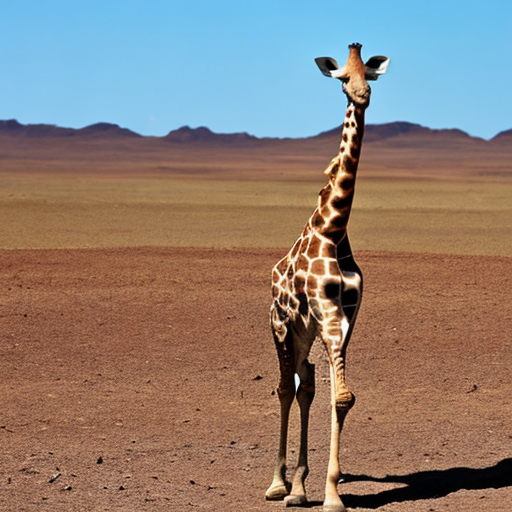

  0%|          | 0/50 [00:00<?, ?it/s]

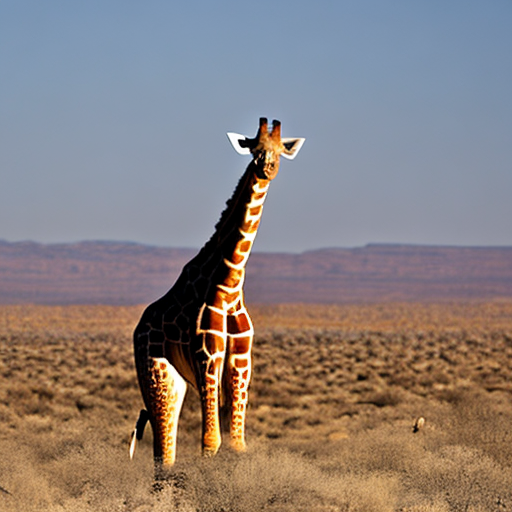

  0%|          | 0/50 [00:00<?, ?it/s]

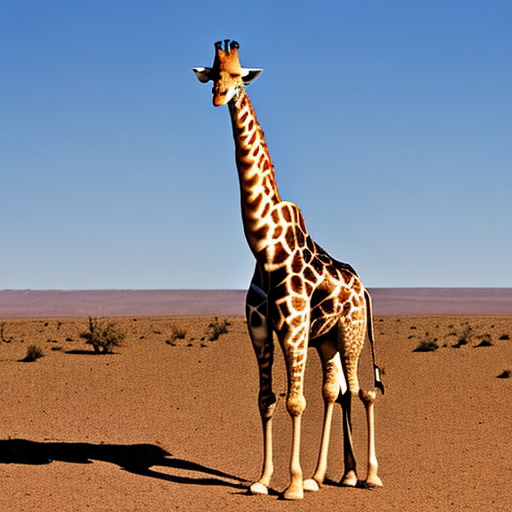

NameError: name 'get_clip_score' is not defined

In [1]:
from diffusers import StableDiffusionPipeline
import torch

model_path = "./soptimpair4_lora_100_base_2"
pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", )
# pipe.unet.load_attn_procs(model_path)
pipe.load_lora_weights(model_path)
pipe.to("cuda")

prompt = "A lone giraffe in a barren landscape, with only a single cactus plant for company. Background: rocky desert with scorching sun and clear blue sky."

SEED = 24 
generator = torch.Generator(device="cuda").manual_seed(SEED)

image = pipe(prompt, num_inference_steps=50, guidance_scale=9, generator = generator, cross_attention_kwargs={"scale":0.0}).images[0]
display(image)

image1 = pipe(prompt, num_inference_steps=50, guidance_scale=9, generator = generator, cross_attention_kwargs={"scale":0.2}).images[0]
display(image1)

image2 = pipe(prompt, num_inference_steps=50, guidance_scale=9, generator = generator, cross_attention_kwargs={"scale":0.4}).images[0]
display(image2)

# image.save("test.png")
print(get_clip_score(image, prompt))
print(get_clip_score(image1, prompt))
print(get_clip_score(image2, prompt))

In [3]:
# image.save("test.png")
print(get_clip_score(image, prompt))
print(get_clip_score(image1, prompt))
print(get_clip_score(image2, prompt))

0.276611328125
0.289306640625
0.279052734375


In [19]:
import torch
from torchmetrics.multimodal.clip_score import CLIPScore
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create CLIPScore metric
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch32").to(device)

# Move the image tensors to the appropriate device
image_tensor = transform(image).unsqueeze(0).to(device)

# Adjust the image tensor values to lie within [0, 1]
image_tensor = (image_tensor + 1) / 2  # Assuming the original range is [-1, 1]

# Update CLIPScore metric with image tensor
metric.update(image_tensor, prompt)

# Plot CLIPScore metric
fig_, ax_ = metric.plot()

# Print CLIPScore metric
print(metric.compute())

####################################
image_tensor1 = transform(image1).unsqueeze(0).to(device)

# Adjust the image tensor values to lie within [0, 1]
image_tensor1 = (image_tensor1 + 1) / 2  # Assuming the original range is [-1, 1]

# Update CLIPScore metric with image tensor
metric.update(image_tensor1, prompt)

# Plot CLIPScore metric
fig_, ax_ = metric.plot()

# Print CLIPScore metric
print(metric.compute())
####################################
image_tensor2 = transform(image2).unsqueeze(0).to(device)
# Adjust the image tensor values to lie within [0, 1]
image_tensor2 = (image_tensor2 + 1) / 2  # Assuming the original range is [-1, 1]

# Update CLIPScore metric with image tensor
metric.update(image_tensor2, prompt)

# Plot CLIPScore metric
fig_, ax_ = metric.plot()

# Print CLIPScore metric
print(metric.compute())

fig_, ax_ = metric.plot()

tensor(20.9591, device='cuda:0')
tensor(20.9868, device='cuda:0')
tensor(20.9820, device='cuda:0')


In [ ]:
import torch
from torchmetrics.multimodal.clip_score import CLIPScore
import torchvision.transforms as transforms

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create CLIPScore metric
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch32").to(device)

# Move the image tensors to the appropriate device
image_tensor = transform(image).unsqueeze(0).to(device)
image_tensor1 = transform(image1).unsqueeze(0).to(device)
image_tensor2 = transform(image2).unsqueeze(0).to(device)

val = []
# Adjust the image tensor values to lie within [0, 1]
image_tensor = (image_tensor + 1) / 2  # Assuming the original range is [-1, 1]
image_tensor1 = (image_tensor1 + 1) / 2  # Assuming the original range is [-1, 1]
image_tensor2 = (image_tensor2 + 1) / 2  # Assuming the original range is [-1, 1]

# Update CLIPScore metric with image tensor
val.append(metric.update(image_tensor, prompt))
val.append(metric.update(image_tensor1, prompt))
val.append(metric.update(image_tensor2, prompt))

# Plot CLIPScore metric
fig_, ax_ = metric.plot(val)

In [8]:
print(m0)
print(m1)
print(m2)

None
None
None


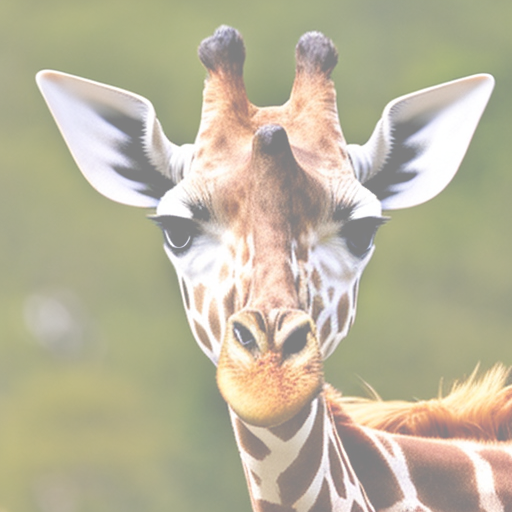

In [27]:
from PIL import Image

# Assuming image_tensor is a batch of images
# Selecting the first image from the batch
single_image_tensor = image_tensor[0]

# Convert single image tensor to PIL Image
image_pil = transforms.ToPILImage()(single_image_tensor.cpu())

# Display the image using PIL
image_pil


In [10]:
from transformers import AutoProcessor, BlipModel

def get_blip_score(image, prompt):
# Load the pre-trained CLIP model and the image
    model = BlipModel.from_pretrained("Salesforce/blip-image-captioning-base")
    processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

    # Preprocess the image and tokenize the text
    inputs = processor(
        text=prompt, images=image, return_tensors="pt", padding=True
        )
    
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    
    return logits_per_image

In [12]:
print(get_blip_score(image, prompt))
print(get_blip_score(image1, prompt))
print(get_blip_score(image2, prompt))



Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

tensor([[-0.0675]], grad_fn=<TBackward0>)


Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

tensor([[0.1901]], grad_fn=<TBackward0>)


Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-image-captioning-base and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.encoder.layer.0.attention.self.value.bias', 'text_model.encoder.layer.0.attention.self.value.weight', 'text_model.encoder.layer.0.crossattention.output.LayerNorm.bias', 'text_model.

tensor([[-0.6724]], grad_fn=<TBackward0>)


model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.31G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.79M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'block_out_channels': [64, 64, 64, 64], 'sample_size': 512} were passed to AutoencoderTiny, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/1 [00:00<?, ?it/s]

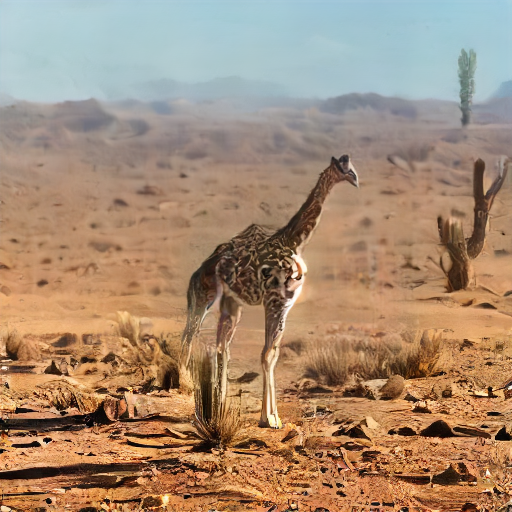

In [1]:
import torch
from diffusers import StableDiffusionPipeline, AutoencoderKL

repo = "IDKiro/sdxs-512-0.9"
seed = 42
weight_type = torch.float32     # or float16

# Load model.
pipe = StableDiffusionPipeline.from_pretrained(repo, torch_dtype=weight_type)

# use original VAE
# pipe.vae = AutoencoderKL.from_pretrained("IDKiro/sdxs-512-0.9/vae_large")
 
pipe.to("cuda")

prompt = "A lone giraffe in a barren landscape, with only a single cactus plant for company. Background: rocky desert with scorching sun and clear blue sky."

# Ensure using 1 inference step and CFG set to 0.
image = pipe(
    prompt, 
    num_inference_steps=1, 
    guidance_scale=0,
    generator=torch.Generator(device="cuda").manual_seed(seed)
).images[0]

#image.save("output.png")
image